In [10]:
import numpy as np
import pandas as pd

import sklearn as sk
import matplotlib.pyplot as plt
#from obspy import Stream, Trace, UTCDateTime
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import pylab as pl
import h5py

import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
os.environ['CUDA_VISIBLE_DEVICES']="0" 

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import ParameterGrid
import re
from sklearn.metrics import confusion_matrix

import os
import sys
classes_dir = 'D:\Thesis_ssd\MasterThesis3.0'
os.chdir(classes_dir)
from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.HelperFunctions import HelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.DataProcessing.DataGenerator import DataGenerator
from Classes.DataProcessing.TimeAugmentor import TimeAugmentor
from Classes.Modeling.DynamicModels import DynamicModels
from Classes.Modeling.StaticModels import StaticModels
from Classes.Modeling.RandomGridSearchDynamicRam import RandomGridSearchDynamicRam
from Classes.Modeling.CustomCallback import CustomCallback
from Classes.Modeling.ResultFitter import ResultFitter
from Classes.Scaling.ScalerFitter import ScalerFitter
from Classes.Scaling.MinMaxScalerFitter import MinMaxScalerFitter
from Classes.Scaling.StandardScalerFitter import StandardScalerFitter
import json
#from Classes import Tf_shutup
#Tf_shutup.Tf_shutup()

from livelossplot import PlotLossesKeras



from matplotlib.colors import ListedColormap

plt.rcParams["figure.figsize"]= (15,15)
helper = HelperFunctions()

import sys
ISCOLAB = 'google.colab' in sys.modules

import random
import pprint

base_dir = 'D:\Thesis_ssd\MasterThesis3.0'
os.chdir(base_dir)




1 Physical GPUs, 1 Logical GPUs


In [12]:
load_args = {
    'earth_explo_only' : False,
    'noise_earth_only' : False,
    'noise_not_noise' : True,
    'downsample' : True,
    'upsample' : True,
    'frac_diff' : 0.3,
    'seed' : 1,
    'subsample_size' : 0.1,
    'balance_non_train_set' : True,
    'use_true_test_set' : False
}
loadData = LoadData(**load_args)
full_ds, train_ds, val_ds, test_ds = loadData.get_datasets()
noise_ds = loadData.noise_ds
handler = DataHandler(loadData)

if load_args['earth_explo_only']:
    full_and_noise_ds = np.concatenate((full_ds, noise_ds))
    timeAug = TimeAugmentor(handler, full_and_noise_ds, seed = load_args['seed'])
else:
    timeAug = TimeAugmentor(handler, full_ds, seed = load_args['seed'])

In [14]:
# Printing data stats:
print(len(train_ds), len(val_ds), len(test_ds))
print("All data:")
classes, counts = handler.get_class_distribution_from_ds(full_ds)
print("Train set:")
classes, counts = handler.get_class_distribution_from_ds(train_ds)
print("Validation set:")
classes, counts = handler.get_class_distribution_from_ds(val_ds)
print("Test set:")
classes, counts = handler.get_class_distribution_from_ds(test_ds)
print("Nr noise samples " + str(len(loadData.noise_ds)))


8463 1692 1129
All data:
Total: 11284, earthquake: 3749, explosion: 3655, noise: 3880
Train set:
Total: 8463, earthquake: 2834, explosion: 2724, noise: 2905
Validation set:
Total: 1692, earthquake: 558, explosion: 549, noise: 585
Test set:
Total: 1129, earthquake: 357, explosion: 382, noise: 390
Nr noise samples 2905


In [15]:
 hyper_grid = {
    "num_layers" : [2,3,4],
    "batch_size" : [64, 128, 256, 512, 1024],
    "epochs" : [50],
    "learning_rate" : [0.1, 0.05, 0.025, 0.005],
    "optimizer" : ["sgd"]
}
model_grid = {
    "start_neurons" : [2,3,4,5,6],
    "use_layerwise_dropout_batchnorm" : [False, True],
    "decay_sequence" : [[1,2,4,4,2,1], [1,4,8,8,4,1], [1,0.5,0.25,0.25,0.5,1], [1,1,1,1,1,1]],
    "dropout_rate" : [0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.001, 0],
    "filters" : [11, 13, 15, 17, 19, 21, 23, 25, 27],
    "kernel_size" : [3, 7, 15, 21, 33, 41],
    "padding" : ["same"],
    "l2_r" : [0.3, 0.2, 0.1, 0.01, 0.001, 0.0001],
    "l1_r" : [0.3, 0.2, 0.1, 0.01, 0.001, 0.0001],
    "activation" : ["tanh"],
    "output_layer_activation" : ["sigmoid"]
}

In [18]:
model_type = "LSTM"
is_lstm = True
num_channels = 3

use_time_augmentor = True
use_scaler = True
use_noise_augmentor = True
detrend = False
use_minmax = False
use_highpass = False
highpass_freq = 0.1

n_picks = 30

use_tensorboard = False
use_liveplots = True
use_custom_callback = False
use_early_stopping = True
start_from_scratch = False

randomGridSearch = RandomGridSearchDynamicRam(loadData, train_ds, val_ds, test_ds, model_type, detrend, use_scaler, 
                                              use_time_augmentor, use_noise_augmentor, use_minmax, use_highpass, n_picks, 
                                              hyper_grid = hyper_grid, model_grid = model_grid, 
                                              use_tensorboard = use_tensorboard, use_liveplots = use_liveplots, 
                                              use_custom_callback = use_custom_callback, use_early_stopping = use_early_stopping,
                                              highpass_freq = highpass_freq, start_from_scratch = start_from_scratch, 
                                              is_lstm = is_lstm, num_channels = num_channels)

Note that highpass and detrend have not been implemented yet in this class.


In [19]:
def clear_tensorboard_dir():
    import os
    import shutil
    path = f"{base_dir}/Tensorboard_dir/fit"
    files = os.listdir(path)
    print(files)
    for f in files:
        shutil.rmtree(os.path.join(path,f))
if use_tensorboard:
    clear_tensorboard_dir()
    %tensorboard --logdir tensorboard_dir/fit

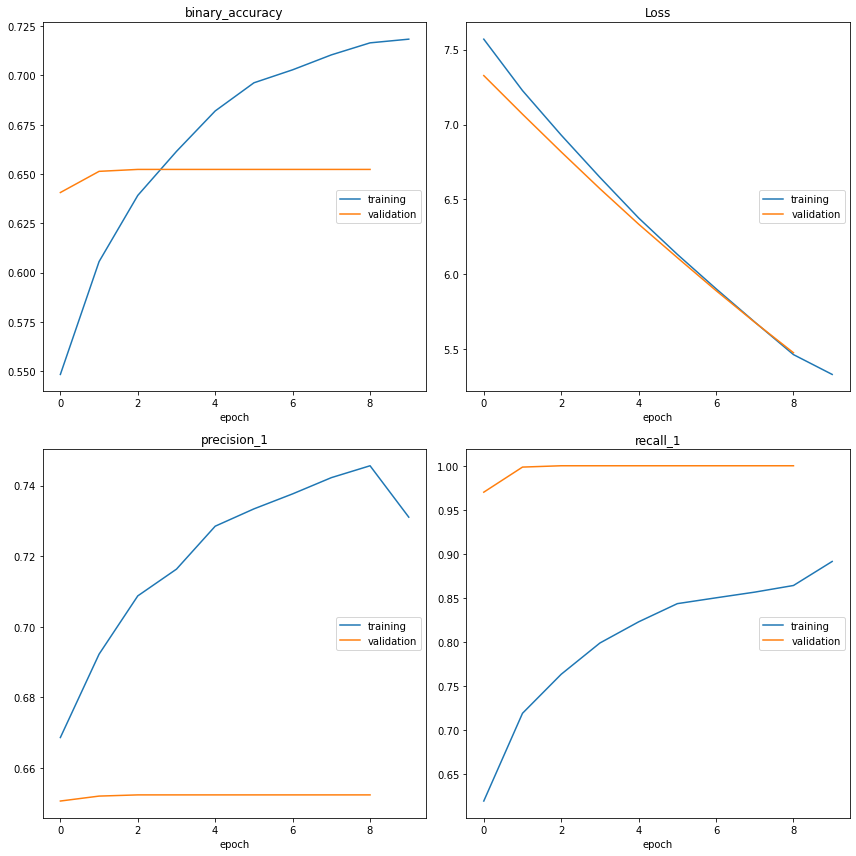

binary_accuracy
	training         	 (min:    0.548, max:    0.718, cur:    0.718)
	validation       	 (min:    0.641, max:    0.652, cur:    0.652)
Loss
	training         	 (min:    5.330, max:    7.570, cur:    5.330)
	validation       	 (min:    5.474, max:    7.327, cur:    5.474)
precision_1
	training         	 (min:    0.669, max:    0.746, cur:    0.731)
	validation       	 (min:    0.651, max:    0.652, cur:    0.652)
recall_1
	training         	 (min:    0.620, max:    0.892, cur:    0.892)
	validation       	 (min:    0.970, max:    1.000, cur:    1.000)
4/8 [==============>...............] - ETA: 1s - loss: 5.3313 - precision_1: 0.7311 - binary_accuracy: 0.7184 - recall_1: 0.8915

C:\Users\Tord\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,binary_accuracy,recall_1
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


KeyboardInterrupt: 

In [20]:
results_df, min_loss, max_accuracy, max_precision, max_recall = randomGridSearch.fit()